In [1]:
import csv
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Input, Activation
from keras.layers import Conv2D, Flatten, MaxPooling2D, AveragePooling2D
from keras.layers import Dropout
from keras.layers import  Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
import cv2
from sklearn.utils import shuffle
import json

%matplotlib inline

Using TensorFlow backend.


In [2]:
#Load the center and left and right camera images
#Resizing the image size

file_names = []
load_side_camera_images_flag = True

X_data = []
y_data = []

scaled_width =160
scaled_height = 80

diff_angle = .175

def load_images():    
    with open('./recording/driving_log.csv', 'r') as csvfile:
        rows = csv.reader(csvfile, delimiter=',')
        next(rows)
        for row in rows:
            angle = float(row[3])
            center_file_name = row[0].strip()
            file_names.append(center_file_name)
            img = Image.open('./recording/' + center_file_name)
            X_data.append(cv2.resize((np.array(img)),(scaled_width,scaled_height)))
            y_data.append(angle)
            
            if load_side_camera_images_flag:
                left_file_name = row[1].strip()            
                file_names.append(left_file_name)
                img = Image.open('./recording/' + left_file_name)
                X_data.append(cv2.resize((np.array(img)),(scaled_width,scaled_height)))
                y_data.append(angle + diff_angle) 
                
                right_file_name = row[2].strip()
                file_names.append(right_file_name)
                img = Image.open('./recording/' + right_file_name)
                X_data.append(cv2.resize((np.array(img)),(scaled_width,scaled_height)))
                y_data.append(angle - diff_angle)    
                
                        
load_images() 
    
print('Data points total: ' , len(X_data))
print('Image shape: ' , X_data[0].shape)
print('Data size in MB: ' , (len(X_data) * X_data[0].shape[0]*X_data[0].shape[1]*X_data[0].shape[2])/(1024*1024) )

Data points total:  24108
Image shape:  (80, 160, 3)
Data size in MB:  882.861328125


In [3]:
#Create training and validationa data
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, random_state=0, test_size=0.2)

print('Train points total: ' , len(X_train))
print('Validation points total: ' , len(X_val))

Train points total:  19286
Validation points total:  4822


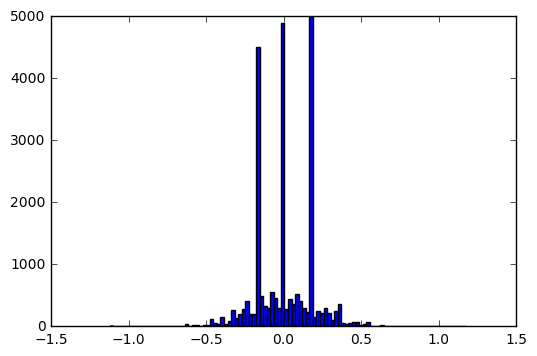

[(0.0, 4361), (-0.175, 4361), (0.175, 4361)]


In [4]:
#Data distribution
#Large number of data points for 3 valuse, and smaller number for rest of data points
from collections import Counter

plt.hist(y_data, 100)
plt.show()

counts = Counter(y_data)
print (counts.most_common(3) )

In [5]:
#Data augmentation. Create new data from existing data by shifting, flipping and changing brightness
#Generator to generate data for the model

def augment(img, angle):        
    img, angle = flip(img, angle)
    img, angle = shift(img, angle)    
    img, angle = brightness(img, angle)                    
    return img, angle

def shift(img, angle):
    shift =  np.around(np.random.randn() * scaled_width * 0.08)
    M = np.float32([[1,0,shift],[0,1,0]])
    rows, cols, _ = img.shape
    img = cv2.warpAffine(img,M,(cols,rows))
    angle += 0.01 * shift 
    return img, angle

def flip(img, angle):
    if np.random.uniform()>0.5:
        img = img[:,::-1,:]
        angle = -angle
    return img, angle

def brightness(img, angle):
    if np.random.uniform()>0.5:
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        deltaBright = .5 + np.random.uniform() * 0.5
        hsv[:, :, 2] = np.around(hsv[:, :, 2] * deltaBright)
        img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return img, angle

def generate_batch(X_train, y_train, batch_size = 128):    
     while True:
        X_train_batch = []
        y_train_batch = []
        
        for x in range(32):
            ind = np.random.randint(len(y_train))
            X_train_batch.append(X_train[ind])
            y_train_batch.append(y_train[ind])
            
            img, angle = augment(X_train[ind], y_train[ind])
            X_train_batch.append(img)
            y_train_batch.append(angle)
                          
        X_train_batch_np = np.array(X_train_batch)
        y_train_batch_np = np.array(y_train_batch)            
        X_train_batch_np, y_train_batch_np = shuffle(X_train_batch_np, y_train_batch_np)            
        yield (X_train_batch_np, y_train_batch_np)

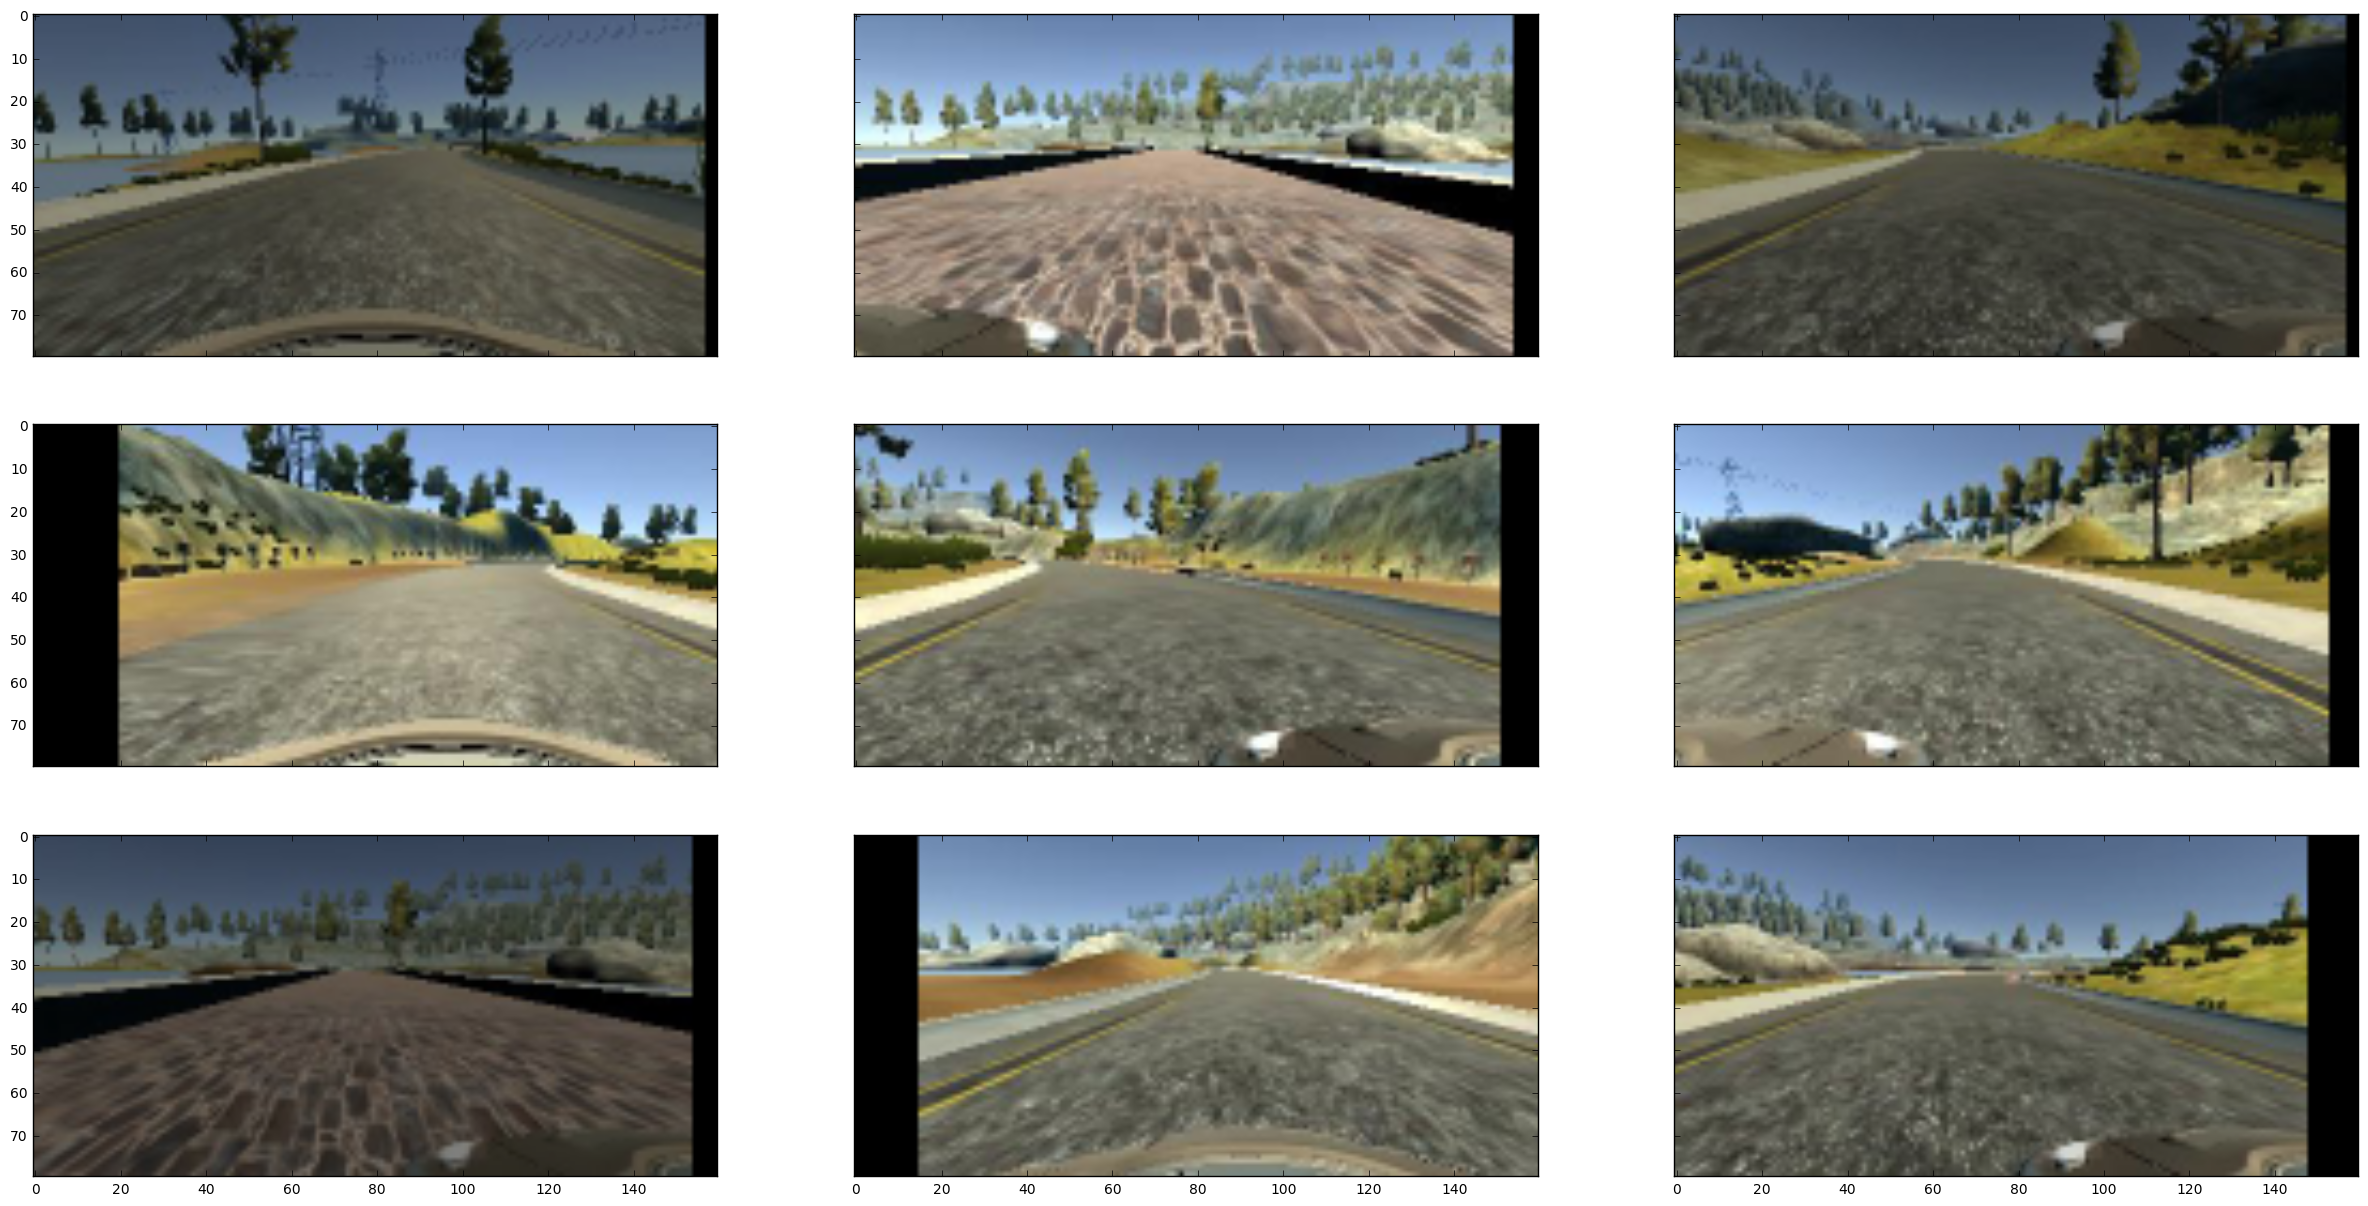

In [21]:
#Showing some sample images generated from augmentation, from shifting, flipping and changing brightness

f , AXS = plt.subplots(3, 3, sharex='col', sharey='row' ,figsize=(30,15))
AXS[0][0].imshow(augment(X_train[2],.2)[0])
AXS[0][1].imshow(augment(X_train[3],.2)[0])
AXS[0][2].imshow(augment(X_train[4],.2)[0])
AXS[1][0].imshow(augment(X_train[5],.2)[0])
AXS[1][1].imshow(augment(X_train[6],.2)[0])
AXS[1][2].imshow(augment(X_train[7],.2)[0])
AXS[2][0].imshow(augment(X_train[8],.2)[0])
AXS[2][1].imshow(augment(X_train[9],.2)[0])
AXS[2][2].imshow(augment(X_train[10],.2)[0])

In [7]:
#Converting to float
X_train = np.array(X_train).astype('float32')
X_val = np.array(X_val).astype('float32')

In [8]:
#Nvidia model
inputShape = (scaled_height, scaled_width, 3)

model = Sequential()

model.add(Lambda(lambda x: x/255.-0.5,input_shape=inputShape))

model.add(Convolution2D(24, 5, 5, subsample=(2,2), border_mode='valid', init='he_normal', input_shape=inputShape))
model.add(ELU())

model.add(Convolution2D(36, 5, 5, subsample=(2,2), border_mode='valid', init='he_normal'))
model.add(ELU())

model.add(Convolution2D(48, 5, 5, subsample=(2,2), border_mode='valid', init='he_normal'))
model.add(ELU())

model.add(Convolution2D(64, 3, 3, subsample=(1,1), border_mode='valid', init='he_normal'))
model.add(ELU())

model.add(Convolution2D(64, 3, 3, subsample=(1,1), border_mode='valid', init='he_normal'))
model.add(ELU())

model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(1164, init='he_normal'))
model.add(ELU())

model.add(Dense(100, init='he_normal'))
model.add(ELU())

model.add(Dense(50, init='he_normal'))
model.add(ELU())

model.add(Dense(10, init='he_normal'))
model.add(ELU())
model.add(Dropout(0.5))

model.add(Dense(1, init='he_normal'))

model.summary()

model.compile(optimizer="adam", loss="mse")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 80, 160, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 38, 78, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 38, 78, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 17, 37, 36)    21636       elu_1[0][0]                      
___________________________________________________________________________________________

In [10]:

generator = generate_batch(X_train, y_train)
model.fit_generator(generator, samples_per_epoch = 16384, validation_data = (X_val, y_val),
                              nb_epoch = 30, verbose=2)

Epoch 1/30
99s - loss: 0.0323 - val_loss: 0.0234
Epoch 2/30
99s - loss: 0.0261 - val_loss: 0.0181
Epoch 3/30
98s - loss: 0.0227 - val_loss: 0.0172
Epoch 4/30
102s - loss: 0.0210 - val_loss: 0.0141
Epoch 5/30
99s - loss: 0.0198 - val_loss: 0.0135
Epoch 6/30
99s - loss: 0.0179 - val_loss: 0.0131
Epoch 7/30
99s - loss: 0.0185 - val_loss: 0.0131
Epoch 8/30
99s - loss: 0.0168 - val_loss: 0.0137
Epoch 9/30
99s - loss: 0.0162 - val_loss: 0.0117
Epoch 10/30
99s - loss: 0.0161 - val_loss: 0.0109
Epoch 11/30
99s - loss: 0.0157 - val_loss: 0.0108
Epoch 12/30
99s - loss: 0.0163 - val_loss: 0.0110
Epoch 13/30
99s - loss: 0.0158 - val_loss: 0.0105
Epoch 14/30
99s - loss: 0.0163 - val_loss: 0.0110
Epoch 15/30
99s - loss: 0.0149 - val_loss: 0.0106
Epoch 16/30
99s - loss: 0.0150 - val_loss: 0.0104
Epoch 17/30
99s - loss: 0.0149 - val_loss: 0.0107
Epoch 18/30
99s - loss: 0.0139 - val_loss: 0.0107
Epoch 19/30
99s - loss: 0.0149 - val_loss: 0.0103
Epoch 20/30
99s - loss: 0.0151 - val_loss: 0.0103
Epoch 21

In [11]:
model_json_string = model.to_json()

with open('model.json', 'w') as outfile:
    outfile.write(model_json_string)

model.save_weights('./model.h5')